In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('__file__'))))
import jReversion as jR
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, balanced_accuracy_score
import networkx as nx
from statannot import add_stat_annotation
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
kmf = KaplanMeierFitter()

In [2]:
oncoprint_pd = pd.read_csv('../data/BLCA_200919/BLCA_TCGA_Cell_2017_DATA_oncoprint_mutCNAex.tsv', sep='\t')
# gene_node_pd = pd.read_csv('../data/BLCA_200919/Grieco_gene_node_mapping.csv')
gene_node_pd = pd.read_csv('../data/BLCA_200919/Grieco_gene_node_oncoKB_mapping.csv')
# print(gene_node_pd.head())

os_pd = pd.read_csv('../data/BLCA_200919/Overall_BLCA_TCGA_Cell_2017.csv')
dfs_pd = pd.read_csv('../data/BLCA_200919/Disease_Free_BLCA_TCGA_Cell_2017.csv')

table_original_network = pd.read_csv('../data/Grieco_table_for_original_network.tsv', sep='\t').sort_values(by='node')

In [97]:
mrna_pd = pd.read_csv('../data/BLCA_200919/mRNA_expression_relative_to_diploid_samples.txt', sep='\t').drop('STUDY_ID', axis=1)
# mrna_pd = pd.read_csv('../data/BLCA_200919/mRNA_expression_relative_to_all_samples.txt', sep='\t').drop('STUDY_ID', axis=1)

In [98]:
mrna_pd['SAMPLE_ID'] = mrna_pd['SAMPLE_ID'].str[:-3]

In [99]:
oncoprint_mut_pd = oncoprint_pd[oncoprint_pd['track_type']=='MUTATIONS']
oncoprint_cna_pd = oncoprint_pd[oncoprint_pd['track_type']=='CNA']
oncoprint_mrna_pd = oncoprint_pd[oncoprint_pd['track_type']=='MRNA']

oncoprint_mrna_melt_pd = pd.melt(oncoprint_mrna_pd, id_vars=['track_name', 'track_type'], var_name='Case ID', value_name='event')
oncoprint_mrna_pivot_pd = pd.pivot(oncoprint_mrna_melt_pd[['track_name', 'Case ID', 'event']], index='Case ID', columns='track_name', values='event').sort_index()
oncoprint_cna_melt_pd = pd.melt(oncoprint_cna_pd, id_vars=['track_name', 'track_type'], var_name='Case ID', value_name='event')
oncoprint_cna_pivot_pd = pd.pivot(oncoprint_cna_melt_pd[['track_name', 'Case ID', 'event']], index='Case ID', columns='track_name', values='event').sort_index()
oncoprint_mut_melt_pd = pd.melt(oncoprint_mut_pd, id_vars=['track_name', 'track_type'], var_name='Case ID', value_name='event')
oncoprint_mut_pivot_pd = pd.pivot(oncoprint_mut_melt_pd[['track_name', 'Case ID', 'event']], index='Case ID', columns='track_name', values='event').sort_index()


cna_mrna_consistent_pivot_pd = ((oncoprint_cna_pivot_pd == 'Amplification') & (oncoprint_mrna_pivot_pd  == 'mRNA High')) | ((oncoprint_cna_pivot_pd  == 'Deep Deletion') & (oncoprint_mrna_pivot_pd == 'mRNA Low'))
mrna_not_low_pivot_pd = ~(oncoprint_mrna_pivot_pd == 'mRNA Low')

alteration_cna_melt_pd = pd.melt(oncoprint_cna_pivot_pd[cna_mrna_consistent_pivot_pd].reset_index(), id_vars='Case ID', var_name='track_name', value_name='event')
alteration_mut_melt_pd = pd.melt(oncoprint_mut_pivot_pd[mrna_not_low_pivot_pd].reset_index(), id_vars='Case ID', var_name='track_name', value_name='event')                                 

alteration_cna_melt_pd['track_type'] = 'CNA'
alteration_mut_melt_pd['track_type'] = 'MUTATIONS'

alteration_cna_mut_melt_pd = pd.concat([alteration_cna_melt_pd, alteration_mut_melt_pd])
alteration_driver_melt_pd = alteration_mut_melt_pd[alteration_mut_melt_pd['event'].str.contains('passenger')==False]
alteration_cna_driver_melt_pd = pd.concat([alteration_cna_melt_pd, alteration_driver_melt_pd])

oncoprint_node_pd = pd.merge(alteration_cna_driver_melt_pd, gene_node_pd, left_on='track_name', right_on='gene_symbol')
oncoprint_node_class_pd = pd.merge(oncoprint_node_pd.dropna(), table_original_network[['node', 'Class']], left_on='node_name', right_on='node')
oncoprint_node_class_pd['mutation_sign'] = 1*(oncoprint_node_class_pd['oncoKB'] == 'Oncogene') - 1*(oncoprint_node_class_pd['oncoKB'] == 'Tumor Suppressor')
oncoprint_node_class_pd['alteration'] = 1
oncoprint_reverse_controllability = pd.pivot_table(oncoprint_node_class_pd[['Case ID', 'Class', 'alteration']], index='Case ID', columns='Class', values='alteration', aggfunc=np.sum)
oncoprint_reverse_controllability = oncoprint_reverse_controllability.fillna(0)

ValueError: Values must be numeric: no strings, datetimes, objects, etc.

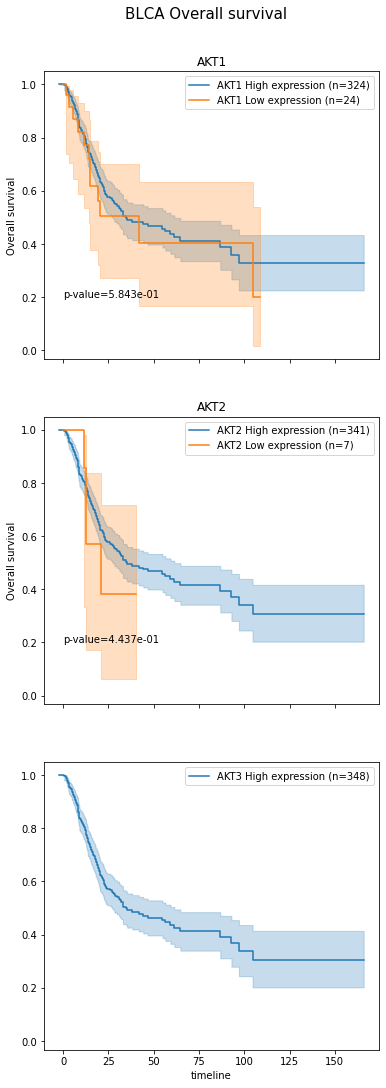

In [115]:
os_oncoprint_pd = pd.merge(mrna_pd, os_pd, left_on='SAMPLE_ID', right_on='Case ID')
os_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, os_oncoprint_pd, left_index=True, right_on='Case ID')
# dfs_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, dfs_pd, left_index=True, right_on='Case ID')
# print(os_oncoprint_pd.head())
f, axes = plt.subplots(3, 1, figsize=(6, 18), sharex=True, sharey=True)
f.suptitle('BLCA Overall survival', fontsize=15, y=0.93)
threshold = 1
ax = axes[0]
data = os_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
C3_altered = data['C3'] > 0.0
C3_unaltered = ~C3_altered
# high = (data['AKT1'] > threshold) & C3_unaltered
low = (data['AKT1'] < -1 * threshold) & C3_unaltered
high = ~low
kmf.fit(T[high], event_observed=E[high], label = 'AKT1 High expression (n=%d)' %np.sum(high))
kmf.plot(ax=ax)
kmf.fit(T[low], event_observed=E[low], label = 'AKT1 Low expression (n=%d)' %np.sum(low))
kmf.plot(ax=ax)
results = logrank_test(T[high], T[low], E[high], E[low], alpha=.99)
ax.text(0.1, 0.2, 'p-value=%.3e'% results.p_value)
ax.set_title('AKT1')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Overall survival')

ax = axes[1]
# T = data['Time (months)']
# E = data['Status'] == 'deceased'
# high = (data['AKT2'] > threshold) & C3_unaltered
low = (data['AKT2'] < -1 * threshold) & C3_unaltered
high = ~low
kmf.fit(T[high], event_observed=E[high], label = 'AKT2 High expression (n=%d)' %np.sum(high))
kmf.plot(ax=ax)
kmf.fit(T[low], event_observed=E[low], label = 'AKT2 Low expression (n=%d)' %np.sum(low))
kmf.plot(ax=ax)
results = logrank_test(T[high], T[low], E[high], E[low], alpha=.99)
ax.text(0.1, 0.2, 'p-value=%.3e'% results.p_value)
ax.set_title('AKT2')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Overall survival')

ax = axes[2]
# T = data['Time (months)']
# E = data['Status'] == 'deceased'
# high = (data['AKT3'] > threshold) & C3_unaltered
low = (data['AKT3'] < -1 * threshold) & C3_unaltered
high = ~low
kmf.fit(T[high], event_observed=E[high], label = 'AKT3 High expression (n=%d)' %np.sum(high))
kmf.plot(ax=ax)
kmf.fit(T[low], event_observed=E[low], label = 'AKT3 Low expression (n=%d)' %np.sum(low))
kmf.plot(ax=ax)
results = logrank_test(T[high], T[low], E[high], E[low], alpha=.99)
ax.text(0.1, 0.2, 'p-value=%.3e'% results.p_value)
ax.set_title('AKT3')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Overall survival')



ValueError: Values must be numeric: no strings, datetimes, objects, etc.

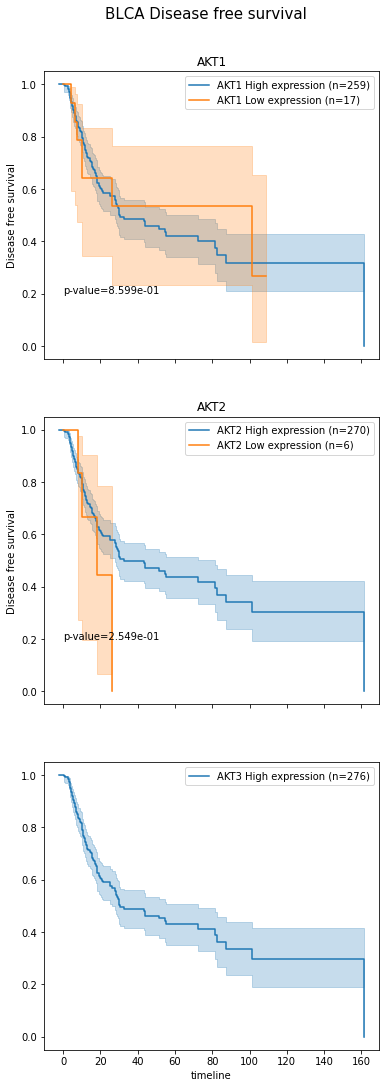

In [116]:
# os_oncoprint_pd = pd.merge(mrna_pd, os_pd, left_on='SAMPLE_ID', right_on='Case ID')
dfs_oncoprint_pd = pd.merge(mrna_pd, dfs_pd, left_on='SAMPLE_ID', right_on='Case ID')
dfs_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, dfs_oncoprint_pd, left_index=True, right_on='Case ID')
# print(os_oncoprint_pd.head())
f, axes = plt.subplots(3, 1, figsize=(6, 18), sharex=True, sharey=True)
f.suptitle('BLCA Disease free survival', fontsize=15, y=0.93)
# threshold = 1.0
ax = axes[0]
data = dfs_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
C3_altered = data['C3'] > 0.0
C3_unaltered = ~C3_altered
# high = (data['AKT1'] > threshold) & C3_unaltered
low = (data['AKT1'] < -1 * threshold) & C3_unaltered
high = ~low
kmf.fit(T[high], event_observed=E[high], label = 'AKT1 High expression (n=%d)' %np.sum(high))
kmf.plot(ax=ax)
kmf.fit(T[low], event_observed=E[low], label = 'AKT1 Low expression (n=%d)' %np.sum(low))
kmf.plot(ax=ax)
results = logrank_test(T[high], T[low], E[high], E[low], alpha=.99)
ax.text(0.1, 0.2, 'p-value=%.3e'% results.p_value)
ax.set_title('AKT1')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Disease free survival')

ax = axes[1]
# T = data['Time (months)']
# E = data['Status'] == 'deceased'
# high = (data['AKT2'] > threshold) & C3_unaltered
low = (data['AKT2'] < -1 * threshold) & C3_unaltered
high = ~low
kmf.fit(T[high], event_observed=E[high], label = 'AKT2 High expression (n=%d)' %np.sum(high))
kmf.plot(ax=ax)
kmf.fit(T[low], event_observed=E[low], label = 'AKT2 Low expression (n=%d)' %np.sum(low))
kmf.plot(ax=ax)
results = logrank_test(T[high], T[low], E[high], E[low], alpha=.99)
ax.text(0.1, 0.2, 'p-value=%.3e'% results.p_value)
ax.set_title('AKT2')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Disease free survival')

ax = axes[2]
# T = data['Time (months)']
# E = data['Status'] == 'deceased'
# high = (data['AKT3'] > threshold) & C3_unaltered
low = (data['AKT3'] < -1 * threshold) & C3_unaltered
high = ~low
kmf.fit(T[high], event_observed=E[high], label = 'AKT3 High expression (n=%d)' %np.sum(high))
kmf.plot(ax=ax)
kmf.fit(T[low], event_observed=E[low], label = 'AKT3 Low expression (n=%d)' %np.sum(low))
kmf.plot(ax=ax)
results = logrank_test(T[high], T[low], E[high], E[low], alpha=.99)
ax.text(0.1, 0.2, 'p-value=%.3e'% results.p_value)
ax.set_title('AKT3')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Disease free survival')
# plt.savefig('../data/BLCA_200919/DFS_survivial_BLCA.pdf', dpi=300)

Text(0, 0.5, 'Overall survival')

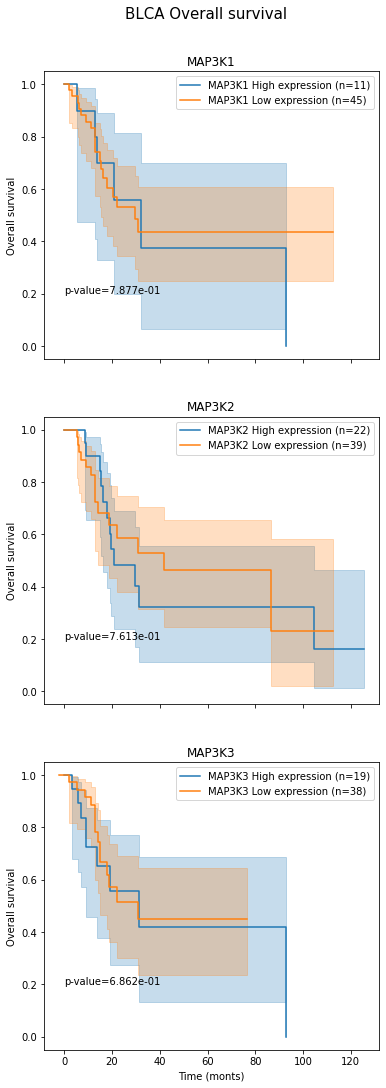

In [107]:
f, axes = plt.subplots(3, 1, figsize=(6, 18), sharex=True, sharey=True)
f.suptitle('BLCA Overall survival', fontsize=15, y=0.93)
# threshold = 1.0
ax = axes[0]
data = os_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
C3_altered = data['C3'] > 0.0
C3_unaltered = ~C3_altered
high = (data['MAP3K1'] > threshold) & C3_unaltered
low = (data['MAP3K1'] < -1 * threshold) & C3_unaltered
kmf.fit(T[high], event_observed=E[high], label = 'MAP3K1 High expression (n=%d)' %np.sum(high))
kmf.plot(ax=ax)
kmf.fit(T[low], event_observed=E[low], label = 'MAP3K1 Low expression (n=%d)' %np.sum(low))
kmf.plot(ax=ax)
results = logrank_test(T[high], T[low], E[high], E[low], alpha=.99)
ax.text(0.1, 0.2, 'p-value=%.3e'% results.p_value)
ax.set_title('MAP3K1')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Overall survival')

ax = axes[1]
# T = data['Time (months)']
# E = data['Status'] == 'deceased'
high = (data['MAP3K2'] > threshold) & C3_unaltered
low = (data['MAP3K2'] < -1 * threshold) & C3_unaltered
kmf.fit(T[high], event_observed=E[high], label = 'MAP3K2 High expression (n=%d)' %np.sum(high))
kmf.plot(ax=ax)
kmf.fit(T[low], event_observed=E[low], label = 'MAP3K2 Low expression (n=%d)' %np.sum(low))
kmf.plot(ax=ax)
results = logrank_test(T[high], T[low], E[high], E[low], alpha=.99)
ax.text(0.1, 0.2, 'p-value=%.3e'% results.p_value)
ax.set_title('MAP3K2')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Overall survival')

ax = axes[2]
# T = data['Time (months)']
# E = data['Status'] == 'deceased'
high = (data['MAP3K3'] > threshold) & C3_unaltered
low = (data['MAP3K3'] < -1 * threshold) & C3_unaltered
kmf.fit(T[high], event_observed=E[high], label = 'MAP3K3 High expression (n=%d)' %np.sum(high))
kmf.plot(ax=ax)
kmf.fit(T[low], event_observed=E[low], label = 'MAP3K3 Low expression (n=%d)' %np.sum(low))
kmf.plot(ax=ax)
results = logrank_test(T[high], T[low], E[high], E[low], alpha=.99)
ax.text(0.1, 0.2, 'p-value=%.3e'% results.p_value)
ax.set_title('MAP3K3')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Overall survival')



Text(0, 0.5, 'Disease-free survival')

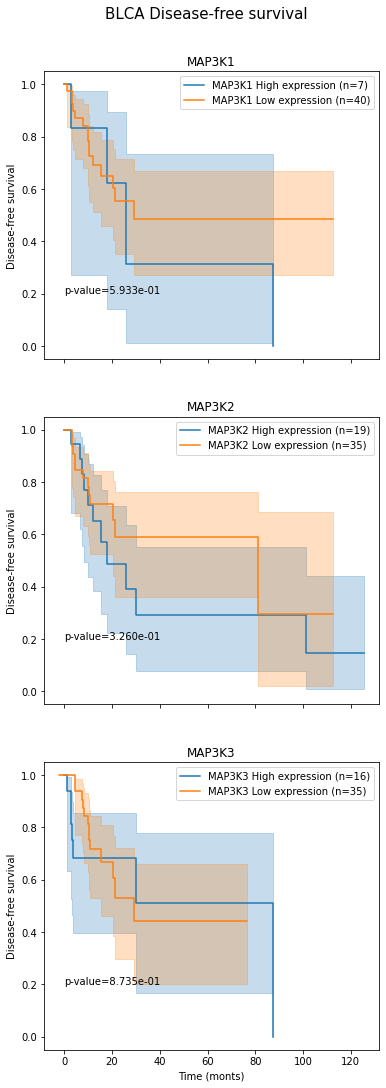

In [108]:
f, axes = plt.subplots(3, 1, figsize=(6, 18), sharex=True, sharey=True)
f.suptitle('BLCA Disease-free survival', fontsize=15, y=0.93)
# threshold = 1.0
ax = axes[0]
data = dfs_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
C3_altered = data['C3'] > 0.0
C3_unaltered = ~C3_altered
high = (data['MAP3K1'] > threshold) & C3_unaltered
low = (data['MAP3K1'] < -1 * threshold) & C3_unaltered
kmf.fit(T[high], event_observed=E[high], label = 'MAP3K1 High expression (n=%d)' %np.sum(high))
kmf.plot(ax=ax)
kmf.fit(T[low], event_observed=E[low], label = 'MAP3K1 Low expression (n=%d)' %np.sum(low))
kmf.plot(ax=ax)
results = logrank_test(T[high], T[low], E[high], E[low], alpha=.99)
ax.text(0.1, 0.2, 'p-value=%.3e'% results.p_value)
ax.set_title('MAP3K1')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Disease-free survival')

ax = axes[1]
# T = data['Time (months)']
# E = data['Status'] == 'deceased'
high = (data['MAP3K2'] > threshold) & C3_unaltered
low = (data['MAP3K2'] < -1 * threshold) & C3_unaltered
kmf.fit(T[high], event_observed=E[high], label = 'MAP3K2 High expression (n=%d)' %np.sum(high))
kmf.plot(ax=ax)
kmf.fit(T[low], event_observed=E[low], label = 'MAP3K2 Low expression (n=%d)' %np.sum(low))
kmf.plot(ax=ax)
results = logrank_test(T[high], T[low], E[high], E[low], alpha=.99)
ax.text(0.1, 0.2, 'p-value=%.3e'% results.p_value)
ax.set_title('MAP3K2')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Disease-free survival')

ax = axes[2]
# T = data['Time (months)']
# E = data['Status'] == 'deceased'
high = (data['MAP3K3'] > threshold) & C3_unaltered
low = (data['MAP3K3'] < -1 * threshold) & C3_unaltered
kmf.fit(T[high], event_observed=E[high], label = 'MAP3K3 High expression (n=%d)' %np.sum(high))
kmf.plot(ax=ax)
kmf.fit(T[low], event_observed=E[low], label = 'MAP3K3 Low expression (n=%d)' %np.sum(low))
kmf.plot(ax=ax)
results = logrank_test(T[high], T[low], E[high], E[low], alpha=.99)
ax.text(0.1, 0.2, 'p-value=%.3e'% results.p_value)
ax.set_title('MAP3K3')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Disease-free survival')

